# anlaysis

In [4]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))



In [5]:
source("ks_connectivity.R")
source("correlation_connectivity.R")

In [6]:
# data 
ln <- load("../../exp_res_ks_20191002.RData")
ln

[1] "up_res_cc"         "up_res_pair_ez"    "down_res_cc"      
 [4] "down_res_pair_ez"  "up_signature_df"   "down_signature_df"
 [7] "gene_rank_bing"    "compound_name"     "ks_score_df_cc"   
[10] "ks_score_df_pair"  "ks_score_df"

In [12]:
check_overlap <- function(gsea_df, nash_drugs) {
    gsea_df <- gsea_df %>% arrange(desc(connectivity_score))
    lincs_drugs <- tolower(gsea_df$compound_name)

    midx <- na.omit(match(nash_drugs, lincs_drugs))
    overlapped_drugs <- lincs_drugs[midx]
    sum_overlap <- ifelse(lincs_drugs %in% overlapped_drugs, 1, 0)
    #sum_overlap_top5 <- ifelse(lincs_drugs[(5774-289+1):5774] %in% overlapped_drugs, 1, 0)
    sum_overlap_top5 <- ifelse(lincs_drugs[1:289] %in% overlapped_drugs, 1, 0)
    #sum_overlap_top10 <- ifelse(lincs_drugs[(5774-578+1):5774] %in% overlapped_drugs, 1, 0)
    sum_overlap_top10 <- ifelse(lincs_drugs[1:578] %in% overlapped_drugs, 1, 0)
    sum_overlap_top_all <- ifelse(lincs_drugs %in% overlapped_drugs, 1, 0)
    return(c(sum(sum_overlap_top5), sum(sum_overlap_top10)))
}

check_score <- function(score_df, nash_drugs) {
    return(score_df[score_df$compound_name %in% nash_drugs, ])
}

drug_str <- "ACARBOSE AMLODIPINE ATORVASTATIN BETAINE CAFFEINE CENICRIVIROC CHOLECALCIFEROL DABIGATRAN DAPAGLIFLOZIN EMRICASAN ERGOCALCIFEROL EXENATIDE EZETIMIBE FENOFIBRATE GLIMEPIRIDE INSULIN GLARGINE INSULIN HUMAN PRADIGASTAT K-877 PX-102 LIRAGLUTIDE QUINIDINE LOSARTAN ROFLUMILAST METFORMIN ROSIGLITAZONE METRELEPTIN ROSUVASTATIN MGL-3196 SELADELPAR MIDAZOLAM SELONSERTIB SEMAGLUTIDE MT-3995 MUROMONAB-CD3 SIMTUZUMAB NAMODENOSON SITAGUPTIN NIVOCASAN SPIRONOLACTONE OBETICHOLIC ACID TELMISARTAN PENTOXIFYLUNE TOFOGLIFLOZIN PERINDOPRIL URSODIOL PIOGLITAZONE"

nash_drugs <- tolower(unlist(stringr::str_split(drug_str, " ")))

In [7]:
# KS help function
.ks <- function( V, n ) {
  t <- length( V )
  
  if( t == 0 )  {
    return( 0 )
  } else {
    
    #if ( is.unsorted( V ) )
    #  V <- sort( V )
    d_1 <- (1:t) / t - V / n
    a <- max( d_1 )
    d_2 <- V / n - (1:t) / t 
    b <- max(V / n - (0:(t-1)) / t)
    #b <- -min( d ) + 1 / t
    ifelse( a > b, a, -b )
  }
}

.s <- function( V_up, V_down, n ) {
  ks_up <- .ks( V_up, n )
  ks_down <- .ks( V_down, n )
  ifelse( sign( ks_up ) == sign( ks_down ), 0, ks_up - ks_down )
}

.S <- function( scores ) {
  p <- max( scores )
  q <- min( scores )
  ifelse(
         scores == 0,
         0,
         ifelse( scores > 0, scores / p, -scores / q )
         )
}

# main functions
ks_score <- function(up_signature, down_signature, rank_matrix, compound_name) {
    n = 1
    connectivity_score_vec <- c()
    gene_rank_bing <- rank_matrix
    for (i in 1:ncol(gene_rank_bing)) {
        if (i %% 500 == 0)  { print(paste0("INFO: ", i, " Instances."))}
        pert_vec <- gene_rank_bing[, i]
        up_signature <- up_signature[up_signature %in% pert_vec]   
        down_signature <- down_signature[down_signature %in% pert_vec]
        # get teh rank
        up_v <- match(up_signature, pert_vec)
        down_v <- match(down_signature, pert_vec)
        tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
        connectivity_score_vec <- c(connectivity_score_vec, tmp_s)
        
    }
    output_df <- data.frame(compound_name = compound_name, connectivity_score = connectivity_score_vec)
    return(output_df)
    
}

### raw ks score

In [8]:
ks_score_raw <- ks_score(up_signature_df$entrezgene_id, down_signature_df$entrezgene_id, gene_rank_bing, compound_name)

[1] "INFO: 500 Instances."
[1] "INFO: 1000 Instances."
[1] "INFO: 1500 Instances."
[1] "INFO: 2000 Instances."
[1] "INFO: 2500 Instances."
[1] "INFO: 3000 Instances."
[1] "INFO: 3500 Instances."
[1] "INFO: 4000 Instances."
[1] "INFO: 4500 Instances."
[1] "INFO: 5000 Instances."
[1] "INFO: 5500 Instances."


In [11]:
check_overlap(ks_score_raw, nash_drugs)

[1] 2 4

In [13]:
check_score(ks_score_raw, nash_drugs)

,compound_name,connectivity_score
19,amlodipine,0.000000
57,caffeine,0.000000
148,ezetimibe,0.000000
243,perindopril,0.000000
250,pioglitazone,0.000000
295,rosuvastatin,0.000000
579,losartan,0.000000
648,rosiglitazone,0.000000
684,atorvastatin,1.700665
2202,amlodipine,0.000000


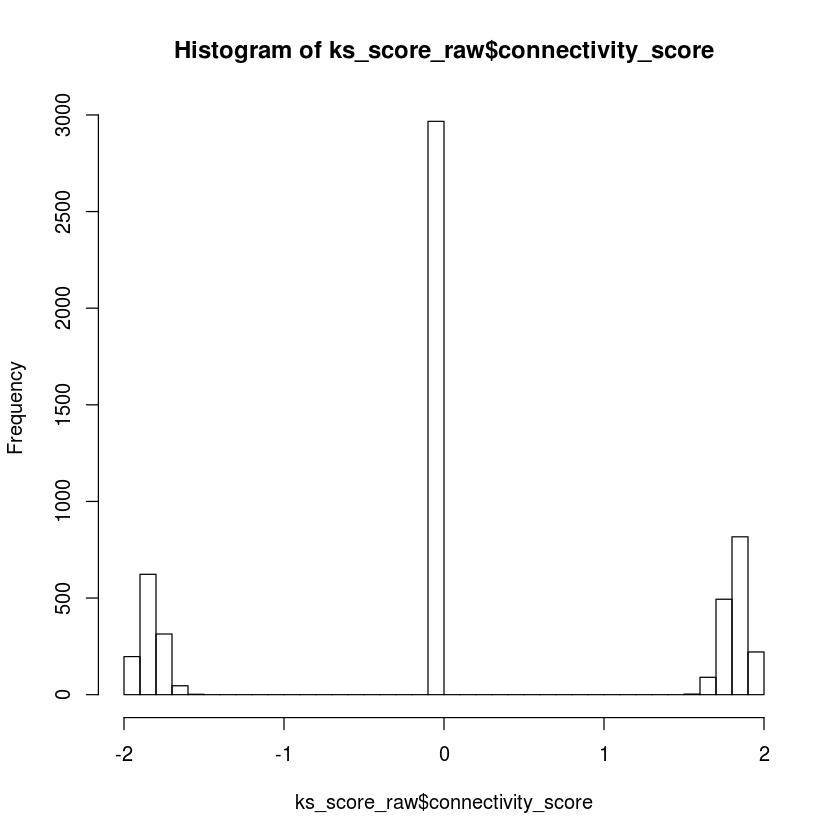

In [15]:
hist(ks_score_raw$connectivity_score, breaks = 50)

In [ ]:
### mean 

In [16]:
ks_score_mean <- ks_score_mean(up_signature_df$entrezgene_id, down_signature_df$entrezgene_id, gene_rank_bing, compound_name)

[1] "INFO: 500 Instances."
[1] "INFO: 1000 Instances."
[1] "INFO: 1500 Instances."
[1] "INFO: 2000 Instances."
[1] "INFO: 2500 Instances."
[1] "INFO: 3000 Instances."
[1] "INFO: 3500 Instances."
[1] "INFO: 4000 Instances."
[1] "INFO: 4500 Instances."
[1] "INFO: 5000 Instances."
[1] "INFO: 5500 Instances."


In [17]:
check_overlap(ks_score_mean, nash_drugs)

[1]  9 10

In [20]:
check_score(ks_score_raw, nash_drugs)


,compound_name,connectivity_score
19,amlodipine,0.000000
57,caffeine,0.000000
148,ezetimibe,0.000000
243,perindopril,0.000000
250,pioglitazone,0.000000
295,rosuvastatin,0.000000
579,losartan,0.000000
648,rosiglitazone,0.000000
684,atorvastatin,1.700665
2202,amlodipine,0.000000


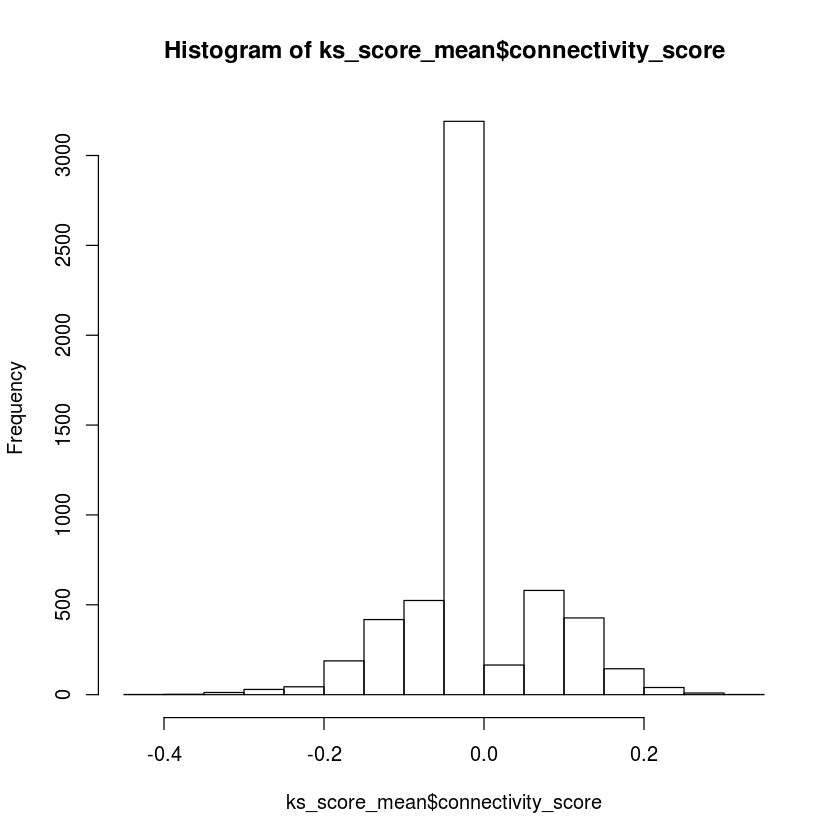

In [19]:
hist(ks_score_mean$connectivity_score, breaks = 20)

In [ ]:
### correlation 

In [24]:
cor_score <- correlation_score_merged(up_signature_df$entrezgene_id, down_signature_df$entrezgene_id, gene_rank_bing, compound_name)

[1] "INFO: 500 Instances."
[1] "INFO: 1000 Instances."
[1] "INFO: 1500 Instances."
[1] "INFO: 2000 Instances."
[1] "INFO: 2500 Instances."
[1] "INFO: 3000 Instances."
[1] "INFO: 3500 Instances."
[1] "INFO: 4000 Instances."
[1] "INFO: 4500 Instances."
[1] "INFO: 5000 Instances."
[1] "INFO: 5500 Instances."


In [25]:
check_overlap(cor_score, nash_drugs)

[1]  9 10

In [26]:
check_score(cor_score, nash_drugs)



,compound_name,connectivity_score
19,amlodipine,-0.033698727
57,caffeine,-0.030010494
148,ezetimibe,0.215545062
243,perindopril,0.242290375
250,pioglitazone,0.092901319
295,rosuvastatin,0.187468643
579,losartan,0.018932245
648,rosiglitazone,-0.207514632
684,atorvastatin,0.372930920
2202,amlodipine,0.006263362


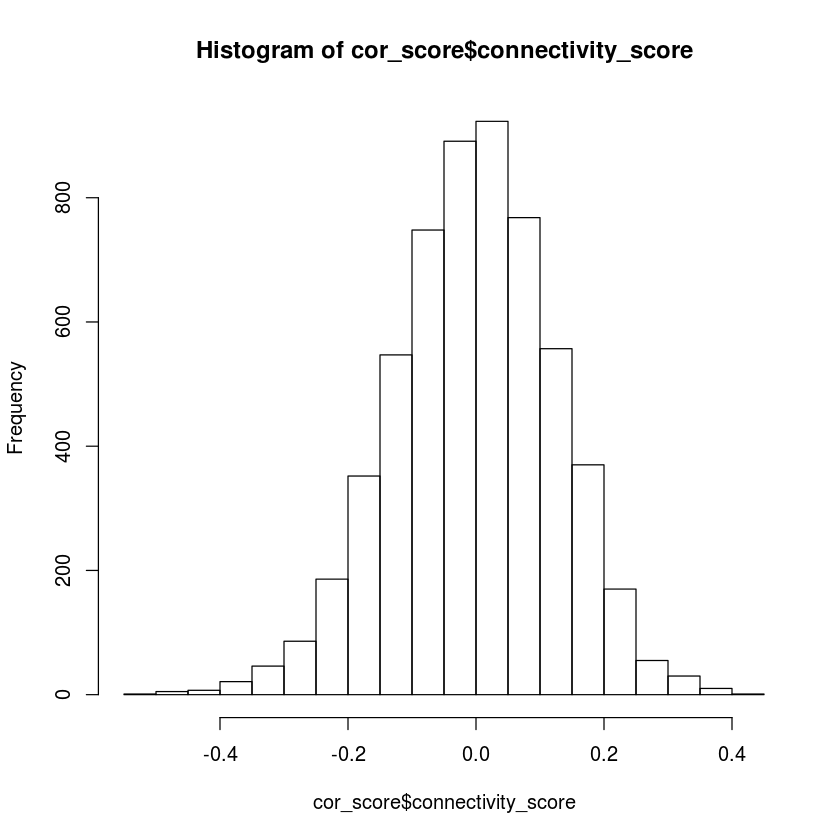

In [27]:
hist(cor_score$connectivity_score, breaks = 20)

In [25]:
head(up_signature_df)

gene_id,log2FC,Paired_TTest.x,P_adjusted.x,entrezgene_id,ensembl_gene_id,nash_1,nash_3,nash_5,nash_6,⋯,nonash_11,nonash_13,nonash_14,nonash_15,nonash_16,nonash_19,nonash_20,logFC,Paired_TTest.y,P_adjusted.y
IGFBP2,2.0973080,0.000202895105445194,0.012531722,3485,ENSG00000115457,5.52600986116163,5.60623844775563,5.80123838936584,4.70580320806404,⋯,7.60762971901251,8.21710655454929,6.05645424467979,7.16480158201681,6.88515902007004,5.90900552371629,5.92910472620911,1.45374314504699,0.000202895105445194,0.0125317222900259
CMYA5,1.1595890,0.000351286063494227,0.015516680,202333,ENSG00000164309,5.10754545068052,4.52639783134358,5.06078860316949,4.70682661957452,⋯,5.44503180669064,6.02702125102626,4.41449391819054,5.51407806636564,5.69491675835204,5.4191293368975,5.32986323229981,0.803765816041033,0.000351286063494227,0.0155166800549362
CA14,1.1577054,7.21898619031281e-05,0.008572901,23632,ENSG00000118298,3.92695884103164,4.52667728148627,3.31228804446142,3.7611840986548,⋯,5.80102330076718,5.28823434108233,3.79072847009234,4.65248678502784,4.98535622245193,4.64702533395229,4.38276310543229,0.802460236526014,7.21898619031281e-05,0.0085729014070367
PPARA,0.9425177,3.8419130807681e-06,0.003508627,5465,ENSG00000186951,7.09040716835301,7.94337760121244,7.06933213381294,7.13154404430531,⋯,7.8350016561528,8.12317442534445,7.90121126226443,8.23448266748219,7.70176370316113,7.82085770678669,7.71299357059367,0.653303496229666,3.8419130807681e-06,0.00350862712101147
CYP1A2,0.8565970,0.00102640671975578,0.026312026,1544,ENSG00000140505,9.34437946338902,10.8478859370914,11.040719491202,10.1625169249533,⋯,10.9719082267521,11.5007525062132,11.0083938173085,10.5601374150956,11.1931455636744,10.9987028630248,10.6536886036463,0.593747788836952,0.00102640671975578,0.0263120262966165
CDH23,0.8272671,7.71817164972887e-05,0.008742475,64072,ENSG00000107736,5.23963135189243,6.22435109678499,5.37161154805623,5.10531271851035,⋯,5.99937447328316,5.50561453595297,5.26636501596013,6.00836272358323,6.1225297657928,5.52887612781896,5.65554151422607,0.573417879203735,7.71817164972887e-05,0.00874247473998747


In [28]:
### comparison between correlation and mean ks score

cbind(check_score(cor_score, nash_drugs), check_score(ks_score_mean, nash_drugs))



,compound_name,connectivity_score,compound_name,connectivity_score
19,amlodipine,-0.033698727,amlodipine,0.00000000
57,caffeine,-0.030010494,caffeine,0.00000000
148,ezetimibe,0.215545062,ezetimibe,0.15088110
243,perindopril,0.242290375,perindopril,0.13128215
250,pioglitazone,0.092901319,pioglitazone,0.09923008
295,rosuvastatin,0.187468643,rosuvastatin,0.13950424
579,losartan,0.018932245,losartan,0.06668752
648,rosiglitazone,-0.207514632,rosiglitazone,-0.14384254
684,atorvastatin,0.372930920,atorvastatin,0.23980760
2202,amlodipine,0.006263362,amlodipine,0.00000000


In [6]:
head(ks_score_vec)

compound_name,connectivity_score
rutin,1.885672
tyrphostin-AG-82,0.000000
AG-957,0.000000
alaproclate,1.924409
albendazole,0.000000
alclometasone,-1.766389


In [8]:
head(ks_score_vec)

compound_name,connectivity_score
rutin,0.1765889
tyrphostin-AG-82,0.1579521
AG-957,-0.1862921
alaproclate,0.0000000
albendazole,-0.3197563
alclometasone,0.0000000


In [9]:
head(ks_score_df)

compound_name,connectivity_score
BRD-K02269790,0.5270061
PD-0325901,0.5120179
BRD-K92981876,0.5014134
atorvastatin,0.4960147
domperidone,0.4903424
tamoxifen,0.4766998


In [11]:
dim(ks_score_vec[which(ks_score_vec$connectivity_score > 1.9), ])

[1] 221   2

In [14]:
ks_score_vec[which(ks_score_vec$compound_name == "atorvastatin"), ]

,compound_name,connectivity_score
684,atorvastatin,1.700665
4602,atorvastatin,1.850435
4603,atorvastatin,1.938382
4866,atorvastatin,0.000000
4867,atorvastatin,1.878150


In [17]:
dim(ks_score_vec[which(ks_score_vec$connectivity_score > 1.85), ])

[1] 649   2

In [11]:
#
up_signature <- up_signature_df$entrezgene_id
down_signature <- down_signature_df$entrezgene_id
i = which(ks_score_vec == 0.4960147)
pert_vec <- gene_rank_bing[, i]
up_signature <- up_signature[up_signature %in% pert_vec]   
down_signature <- down_signature[down_signature %in% pert_vec]
# get teh rank
up_v <- match(up_signature, pert_vec)
down_v <- match(down_signature, pert_vec)
tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
tmp_s
        


[1] 0

In [68]:
check_overlap(ks_score_vec, nash_drugs)

[1] 2 4

In [52]:
check_overlap(ks_score_df, nash_drugs)

[1] 11 12

In [65]:
gsea_df <- ks_score_vec %>% arrange(desc(connectivity_score))
lincs_drugs <- tolower(gsea_df$compound_name)
midx <- na.omit(match(nash_drugs, lincs_drugs))
overlapped_drugs <- lincs_drugs[midx]

In [66]:
overlapped_drugs

[1] "acarbose"       "amlodipine"     "atorvastatin"   "caffeine"      
 [5] "ezetimibe"      "fenofibrate"    "glimepiride"    "quinidine"     
 [9] "losartan"       "rosiglitazone"  "rosuvastatin"   "spironolactone"
[13] "telmisartan"    "perindopril"    "pioglitazone"

In [67]:
sum(ifelse(lincs_drugs[1:289] %in% overlapped_drugs, 1, 0))

[1] 2

### Rank based on p adjusted 

In [26]:
up_signature_df_pvalue <- up_signature_df %>% arrange(P_adjusted.x)
down_signature_df_pvalue <- down_signature_df %>% arrange(P_adjusted.x)

In [28]:
ks_score_vec_p <- ks_score(up_signature_df_pvalue$entrezgene_id, down_signature_df_pvalue$entrezgene_id, gene_rank_bing, compound_name)

[1] "INFO: 500 Instances."
[1] "INFO: 1000 Instances."
[1] "INFO: 1500 Instances."
[1] "INFO: 2000 Instances."
[1] "INFO: 2500 Instances."
[1] "INFO: 3000 Instances."
[1] "INFO: 3500 Instances."
[1] "INFO: 4000 Instances."
[1] "INFO: 4500 Instances."
[1] "INFO: 5000 Instances."
[1] "INFO: 5500 Instances."


In [33]:
ks_score_vec_p <- ks_score_vec_p %>% arrange(desc(connectivity_score)) 

In [34]:
check_overlap(ks_score_vec_p, nash_drugs)

[1] 1 3

In [39]:
ks_score_vec_p[which(ks_score_vec_p$compound_name == "atorvastatin"),]

,compound_name,connectivity_score
592,atorvastatin,1.844126
1072,atorvastatin,1.784715
3813,atorvastatin,0.000000
3947,atorvastatin,0.000000
3948,atorvastatin,0.000000


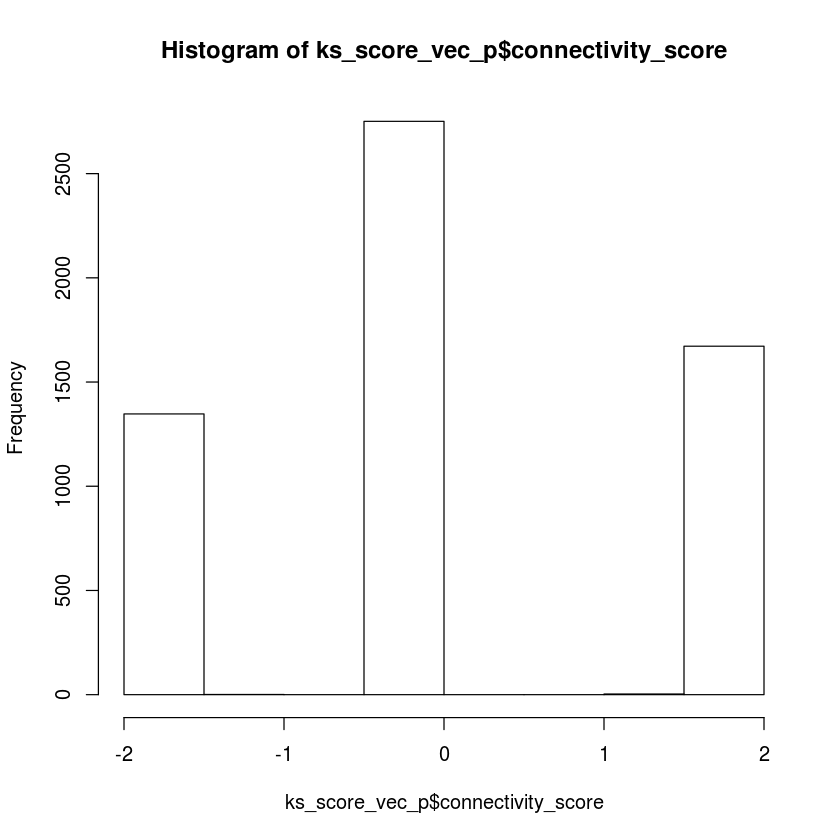

In [40]:
hist(ks_score_vec_p$connectivity_score)

In [23]:
#
ks_detail <- function() {
    up_signature <- up_signature_df$entrezgene_id
    down_signature <- down_signature_df$entrezgene_id
    i = high_score_idx[12]
    pert_vec <- gene_rank_bing[, i]
    up_signature <- up_signature[up_signature %in% pert_vec]   
    down_signature <- down_signature[down_signature %in% pert_vec]
    # get teh rank
    up_v <- match(up_signature, pert_vec)
    down_v <- match(down_signature, pert_vec)
    tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
    tmp_s
    up_detail <- .ks_detail(up_v, nrow(gene_rank_bing))
    down_detail <- .ks_detail(down_v, nrow(gene_rank_bing))
}
        

[1] 0.4960147

In [25]:
.s

function (V_up, V_down, n) 
{
    ks_up <- .ks(V_up, n)
    ks_down <- .ks(V_down, n)
    ifelse(sign(ks_up) == sign(ks_down), 0, ks_up - ks_down)
}
<bytecode: 0xad8fd80>

In [28]:
.ks

function (V, n) 
{
    t <- length(V)
    if (t == 0) {
        return(0)
    }
    else {
        if (is.unsorted(V)) 
            V <- sort(V)
        d <- (1:t)/t - V/n
        a <- max(d)
        b <- -min(d) + 1/t
        ifelse(a > b, a, -b)
    }
}
<bytecode: 0xadf268>

In [33]:
.ks_detail <- function (V, n) 
{
    t <- length(V)
    if (t == 0) {
        return(0)
    }
    else {
        if (is.unsorted(V)) 
            V <- sort(V)
        d <- (1:t)/t - V/n
        a <- max(d)
        b <- -min(d) + 1/t
        #ifelse(a > b, a, -b)
        return(d)
    }
}
#
ks_detail <- function() {
    up_signature <- up_signature_df$entrezgene_id
    down_signature <- down_signature_df$entrezgene_id
    i = high_score_idx[12]
    pert_vec <- gene_rank_bing[, i]
    up_signature <- up_signature[up_signature %in% pert_vec]   
    down_signature <- down_signature[down_signature %in% pert_vec]
    # get teh rank
    up_v <- match(up_signature, pert_vec)
    down_v <- match(down_signature, pert_vec)
    tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
    tmp_s
    up_detail <- .ks_detail(up_v, nrow(gene_rank_bing))
    down_detail <- .ks_detail(down_v, nrow(gene_rank_bing))
}
        
ks_score <- function(up_signature, down_signature, rank_matrix, compound_name) {
    n = 1
    connectivity_score_vec <- c()
    gene_rank_bing <- rank_matrix
    up_signature <- up_signature[up_signature %in% pert_vec]   
    down_signature <- down_signature[down_signature %in% pert_vec]
    for (i in 1:ncol(gene_rank_bing)) {
        if (i %% 500 == 0)  { print(paste0("INFO: ", i, " Instances."))}
        pert_vec <- gene_rank_bing[, i]
        # get teh rank
        up_v <- match(up_signature, pert_vec)
        down_v <- match(down_signature, pert_vec)
        tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
        connectivity_score_vec <- c(connectivity_score_vec, tmp_s)
        
    }
    output_df <- data.frame(compound_name = compound_name, connectivity_score = connectivity_score_vec)
    return(output_df)
    
}

In [26]:
.ks(up_v, nrow(gene_rank_bing))

[1] 0.3233306

In [27]:
.ks(down_v, nrow(gene_rank_bing))

[1] -0.1726841

In [37]:
up_detail <- .ks_detail(up_v, nrow(gene_rank_bing))

In [39]:
down_detail <- .ks_detail(down_v, nrow(gene_rank_bing))

In [38]:
up_detail

[1] 0.01134748 0.01905824 0.02853822 0.04106518 0.05034857 0.05540551
 [7] 0.06164192 0.06217753 0.07608055 0.08615026 0.09621998 0.10992641
[13] 0.11989784 0.13203164 0.13531936 0.13467549 0.14769389 0.15422518
[19] 0.15859409 0.17279197 0.18237024 0.19440575 0.20260795 0.21257938
[25] 0.22107646 0.22859064 0.23119033 0.23261055 0.19333880 0.20389997
[31] 0.21691837 0.22875730 0.24167742 0.24693094 0.24776142 0.25881403
[37] 0.25885819 0.25221864 0.26209178 0.26341370 0.27672698 0.27736088
[43] 0.28556309 0.28993199 0.30363843 0.31596881 0.30962413 0.32333057
[49] 0.31216970 0.29206446 0.30095469 0.31505429 0.30477802 0.30374099
[55] 0.28452036 0.29252599 0.27959590 0.24966168 0.26002627 0.23166469
[61] 0.23898229 0.23961619 0.24418167 0.21975168 0.22618468 0.21168195
[67] 0.20258516 0.19732168 0.20935718

In [40]:
down_detail

[1]  0.008952635  0.010042090  0.006708506  0.006127034  0.013703613
  [6]  0.021083612  0.019814113  0.026800953  0.008920485 -0.023506868
 [11] -0.039224962 -0.082857348 -0.087861858 -0.082251074 -0.085682948
 [16] -0.116635955 -0.110730302 -0.101875956 -0.094594247 -0.089278333
 [21] -0.088188878 -0.088278900 -0.079621134 -0.072241135 -0.074690112
 [26] -0.084805689 -0.080865832 -0.088131006 -0.080652717 -0.075926542
 [31] -0.070512338 -0.073845922 -0.075213711 -0.093978788 -0.114021631
 [36] -0.109590325 -0.151256915 -0.163338288 -0.160086458 -0.160176481
 [41] -0.157121231 -0.158489020 -0.151010731 -0.156604980 -0.155024076
 [46] -0.148626975 -0.140067498 -0.137307118 -0.132777522 -0.145645213
 [51] -0.143376281 -0.134718515 -0.142081979 -0.136078037 -0.127321981
 [56] -0.119843692 -0.114626067 -0.107344358 -0.100062648 -0.115092714
 [61] -0.112528913 -0.113110384 -0.107303021 -0.104935799 -0.102666868
 [66] -0.103838077 -0.110218644 -0.117385529 -0.111381587 -0.103903298
 [71] -0.097604486 -0.096515031 -0.091199117 -0.091092560 -0.085776645
 [76] -0.084195742 -0.079862725 -0.085555264 -0.081418826 -0.084850701
 [81] -0.084449274 -0.075201770 -0.069296117 -0.068698111 -0.076651314
 [86] -0.083031881 -0.075258723 -0.066502667 -0.059614116 -0.059900718
 [91] -0.050653214 -0.044550981 -0.037564141 -0.035295209 -0.026244284
 [96] -0.033116300 -0.035270407 -0.032018578 -0.036236770 -0.026989265
[101] -0.029241662 -0.024613776 -0.015562851 -0.008576011 -0.011418147
[106] -0.003055250  0.004521329

In [1]:
getwd()

[1] "/gpfs/ysm/project/zhao/zy92/NASH/dr_multiomics/code"

In [ ]:
### postive case

In [ ]:
source("ks_s")
.ks_detail <- function (V, n) 
{
    t <- length(V)
    if (t == 0) {
        return(0)
    }
    else {
        if (is.unsorted(V)) 
            V <- sort(V)
        d <- (1:t)/t - V/n
        a <- max(d)
        b <- -min(d) + 1/t
        #ifelse(a > b, a, -b)
        return(d)
    }
}
#
ks_detail <- function() {
    up_signature <- up_signature_df$entrezgene_id
    down_signature <- down_signature_df$entrezgene_id
    i = high_score_idx[12]
    pert_vec <- gene_rank_bing[, i]
    up_signature <- up_signature[up_signature %in% pert_vec]   
    down_signature <- down_signature[down_signature %in% pert_vec]
    # get teh rank
    up_v <- match(up_signature, pert_vec)
    down_v <- match(down_signature, pert_vec)
    tmp_s <- .s(up_v, down_v, nrow(gene_rank_bing))
    tmp_s
    up_detail <- .ks_detail(up_v, nrow(gene_rank_bing))
    down_detail <- .ks_detail(down_v, nrow(gene_rank_bing))
}

In [1]:
getwd()

[1] "/gpfs/ysm/project/zhao/zy92/NASH/dr_multiomics/code"

In [44]:
(ks_score_vec %>% arrange(desc(connectivity_score)))[1:20,]

compound_name,connectivity_score
BRD-A66604020,1.968646
BRD-K63938928,1.967073
flunarizine,1.966886
pifithrin-mu,1.964134
BRD-A17757596,1.962936
alpha-estradiol,1.960694
genistein,1.959111
BRD-K06071925,1.958997
dydrogesterone,1.956253
U0126,1.955761


In [49]:
(ks_score_vec %>% arrange(desc(connectivity_score)))[280:290,]

,compound_name,connectivity_score
280,tacrolimus,1.891758
281,BRD-K86565213,1.891596
282,TL-HRAS-61,1.891488
283,benzylpenicillin,1.890990
284,Y-26763,1.890850
285,desoximetasone,1.890777
286,BRD-K47147974,1.890658
287,BRD-K84762162,1.890161
288,raloxifene,1.890081
289,PCI-34051,1.890015


In [51]:
5774 * 0.05

[1] 288.7

In [54]:
tmp_df <- ks_score_vec[which(ks_score_vec$compound_name %in% nash_drugs),]

In [58]:
tmp_df

,compound_name,connectivity_score
19,amlodipine,0.000000
57,caffeine,0.000000
148,ezetimibe,0.000000
243,perindopril,0.000000
250,pioglitazone,0.000000
295,rosuvastatin,0.000000
579,losartan,0.000000
648,rosiglitazone,0.000000
684,atorvastatin,1.700665
2202,amlodipine,0.000000


In [57]:
tmp_df[which(tmp_df$connectivity_score > 1.89),]

,compound_name,connectivity_score
3427,rosiglitazone,1.933630
4603,atorvastatin,1.938382


In [48]:
dim(ks_score_vec[which(ks_score_vec$compound_name %in% nash_drugs),])

[1] 30  2

In [ ]:
show_heatmap <- function(signatures) {
    
}

In [ ]:
up_detail <- .ks_detail(up_v, nrow(gene_rank_bing))

In [69]:
source("ks_connectivity.R")

In [71]:
ks_score_vec_mean <- ks_score_mean(up_signature_df$entrezgene_id, down_signature_df$entrezgene_id, gene_rank_bing, compound_name)

[1] "INFO: 500 Instances."
[1] "INFO: 1000 Instances."
[1] "INFO: 1500 Instances."
[1] "INFO: 2000 Instances."
[1] "INFO: 2500 Instances."
[1] "INFO: 3000 Instances."
[1] "INFO: 3500 Instances."
[1] "INFO: 4000 Instances."
[1] "INFO: 4500 Instances."
[1] "INFO: 5000 Instances."
[1] "INFO: 5500 Instances."


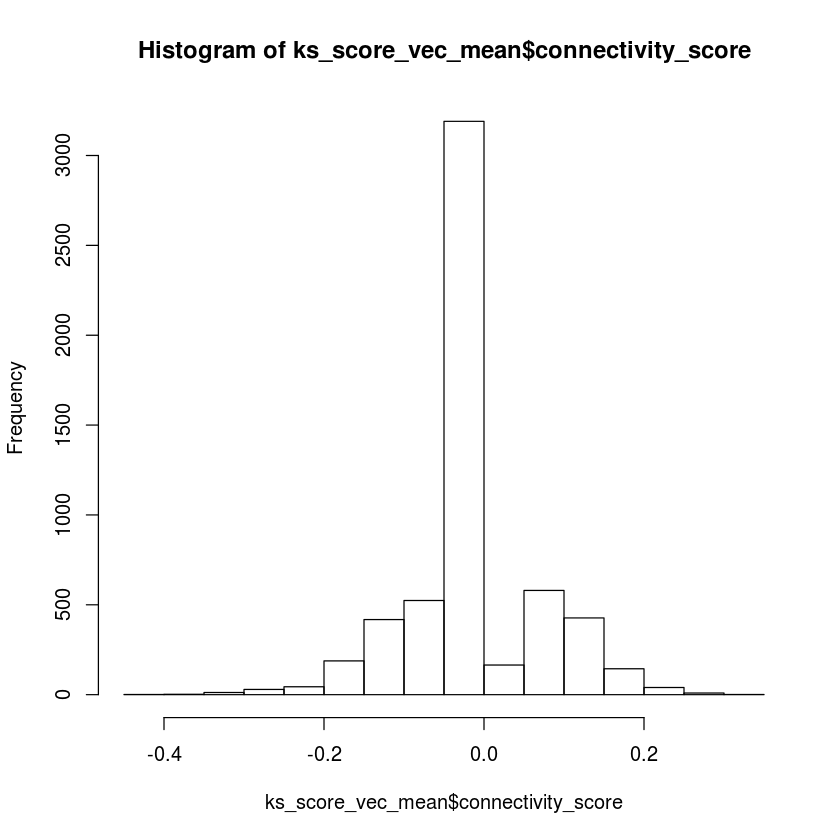

In [73]:
hist(ks_score_vec_mean$connectivity_score)

In [75]:
check_overlap(ks_score_vec_mean, nash_drugs)

[1]  9 10

In [77]:
tmp_df <- ks_score_vec_mean %>% arrange(desc(connectivity_score))

In [80]:
tmp_df[tmp_df$compound_name %in% nash_drugs,]

,compound_name,connectivity_score
2,atorvastatin,0.29626662
11,atorvastatin,0.24929622
19,atorvastatin,0.23980760
62,rosuvastatin,0.19256403
107,atorvastatin,0.17135008
122,spironolactone,0.16772772
187,ezetimibe,0.15088110
219,atorvastatin,0.14684819
272,rosuvastatin,0.13950424
322,perindopril,0.13128215


In [81]:
getwd()

[1] "/gpfs/ysm/project/zhao/zy92/NASH/dr_multiomics/code"

In [82]:
ks_score_vec_mean[1:20,]

compound_name,connectivity_score
rutin,0.05452085
tyrphostin-AG-82,0.03129074
AG-957,-0.05806736
alaproclate,0.00000000
albendazole,-0.14208149
alclometasone,0.00000000
alfuzosin,0.00000000
aliskiren,0.10460597
alprenolol,0.07443579
alrestatin,0.00000000


In [84]:
ks_score_ranked <- ks_score_vec_mean %>% arrange(desc(connectivity_score))

In [87]:
head(ks_score_vec_mean)

compound_name,connectivity_score
rutin,0.05452085
tyrphostin-AG-82,0.03129074
AG-957,-0.05806736
alaproclate,0.00000000
albendazole,-0.14208149
alclometasone,0.00000000


In [88]:
head(ks_score_vec)

compound_name,connectivity_score
rutin,1.885672
tyrphostin-AG-82,0.000000
AG-957,0.000000
alaproclate,1.924409
albendazole,0.000000
alclometasone,-1.766389


In [89]:
ks_score_vec_ranked <- ks_score_vec %>% arrange(desc(connectivity_score))

In [ ]:
cor_score_vec <- correla

In [85]:
ks_score_ranked[1:200, ]

compound_name,connectivity_score
PD-0325901,0.3164465
atorvastatin,0.2962666
BRD-K02269790,0.2921521
BRD-K92981876,0.2778050
BMS-536924,0.2684924
ENMD-2076,0.2674282
PP-110,0.2573817
PD-0325901,0.2553608
domperidone,0.2527890
U-0126,0.2502311


In [ ]:
source("./")

In [ ]:
ks_score_vec_mean <- cor(up_signature_df$entrezgene_id, down_signature_df$entrezgene_id, gene_rank_bing, compound_name)